In [6]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import product
import random
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")

In [7]:
sys.path.append('/Users/ZRC/')

In [8]:
import python_zrc.feature_generation.time_related as tr
import python_zrc.time_series.stationarity as ts
import python_zrc.time_series.decompose as td

In [9]:
%load_ext autoreload
%autoreload 2

## Data Explore

### File descriptions
- **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
- **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
- **sample_submission.csv** - a sample submission file in the correct format.
- **items.csv** - supplemental information about the items/products.
- **item_categories.csv**  - supplemental information about the items categories.
- **shops.csv** - supplemental information about the shops.


### Data fields

- **ID** - an Id that represents a (Shop, Item) tuple within the test set
- **shop_id** - unique identifier of a shop
- **item_id** - unique identifier of a product
- **item_category_id** - unique identifier of item category
- **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
- **item_price** - current price of an item
- **date** - date in format dd/mm/yyyy
- **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- **item_name** - name of item
- **shop_name** - name of shop
- **item_category_name** - name of item category

In [10]:
test = pd.read_csv("data/test.csv")

In [11]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [12]:
pd.read_csv("data/sample_submission.csv").head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [13]:
sales_train = pd.read_csv("data/sales_train.csv")
items = pd.read_csv("data/items.csv")
item_categories = pd.read_csv("data/item_categories.csv")
shops = pd.read_csv("data/shops.csv")

In [14]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [15]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [16]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [17]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [18]:
sales_train.loc[:,"date"] = tr.to_time_format(sales_train,"date","%d.%m.%Y")

In [19]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [20]:
dummyed_time_features = tr.dummy_time_feature(sales_train,"date")
for feature_name in ['tm_year', 'tm_mon', 'tm_mday','tm_wday']:
    sales_train[feature_name] = dummyed_time_features[feature_name]

In [21]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,tm_year,tm_mon,tm_mday,tm_wday
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,2
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,3
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5,5
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,6
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,1


## Outliers

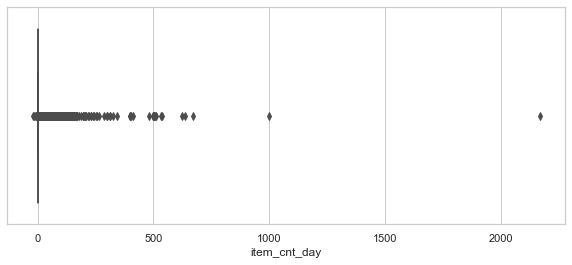

In [27]:
plt.figure(figsize=(10,4))
sns.boxplot(x=sales_train.item_cnt_day)

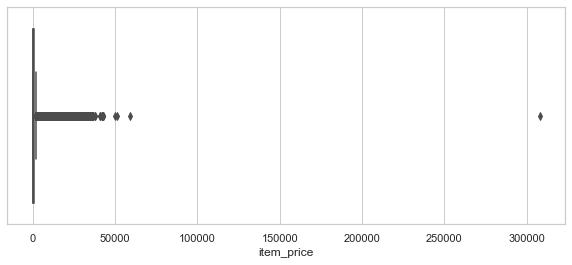

In [28]:
plt.figure(figsize=(10,4))
sns.boxplot(x= sales_train.item_price)

In [29]:
raw_features = sales_train.loc[(sales_train.item_price < 10000) & (sales_train.item_price > 0)]
raw_features = raw_features.loc[(raw_features.item_cnt_day < 1000)]

In [30]:
raw_features.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,tm_year,tm_mon,tm_mday,tm_wday
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,2
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,3
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5,5
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,6
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,1


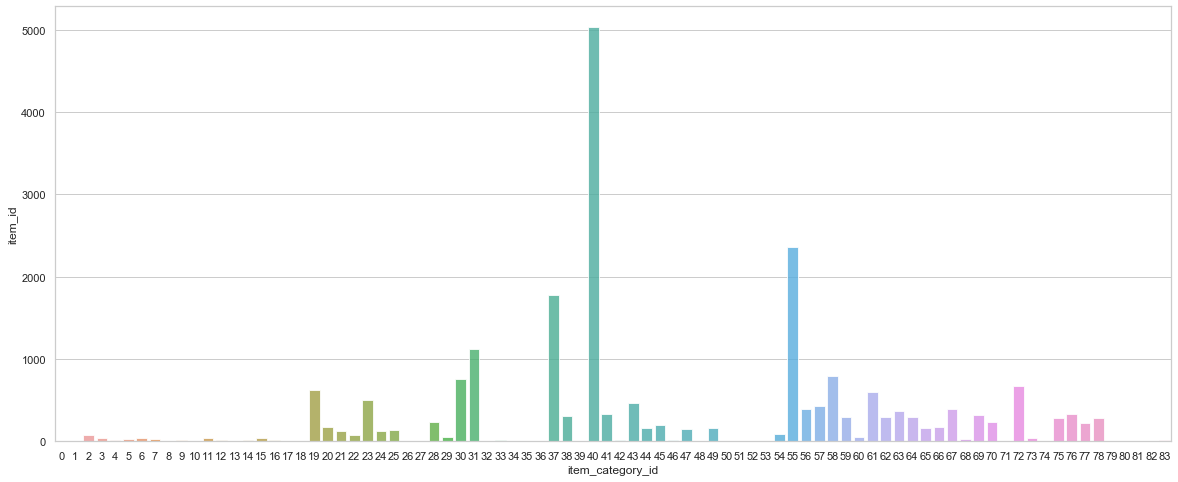

In [31]:
x = items.groupby(["item_category_id"]).count()
plt.figure(figsize=(20,8))
sns.barplot(x.index, x.item_id, alpha=0.8)

## Time Series

### Single Series

First let's compute the total sales per month and plot that data

In [ ]:
item_cnt_month_ts =raw_features.groupby(["date_block_num"])["item_cnt_day"].sum()
item_cnt_month_ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(item_cnt_month_ts);

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(item_cnt_month_ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(item_cnt_month_ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

**Quick observations**: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.

In [ ]:
# multiplicative
res = sm.tsa.seasonal_decompose(item_cnt_month_ts.values,freq=12,model="multiplicative")
# plt.figure(figsize=(20,8))
res.plot()
# fig.show()

We assume an additive model, then we can write

$$yt=St+Tt+Et$$

where $yt$ is the data at period t, $St$ is the seasonal component at period t, $Tt$ is the trend-cycle component at period t and Et is the remainder (or irregular or error) component at period t 

Similarly for Multiplicative model,

$$yt=St x Tt x Et$$

### Stationarity

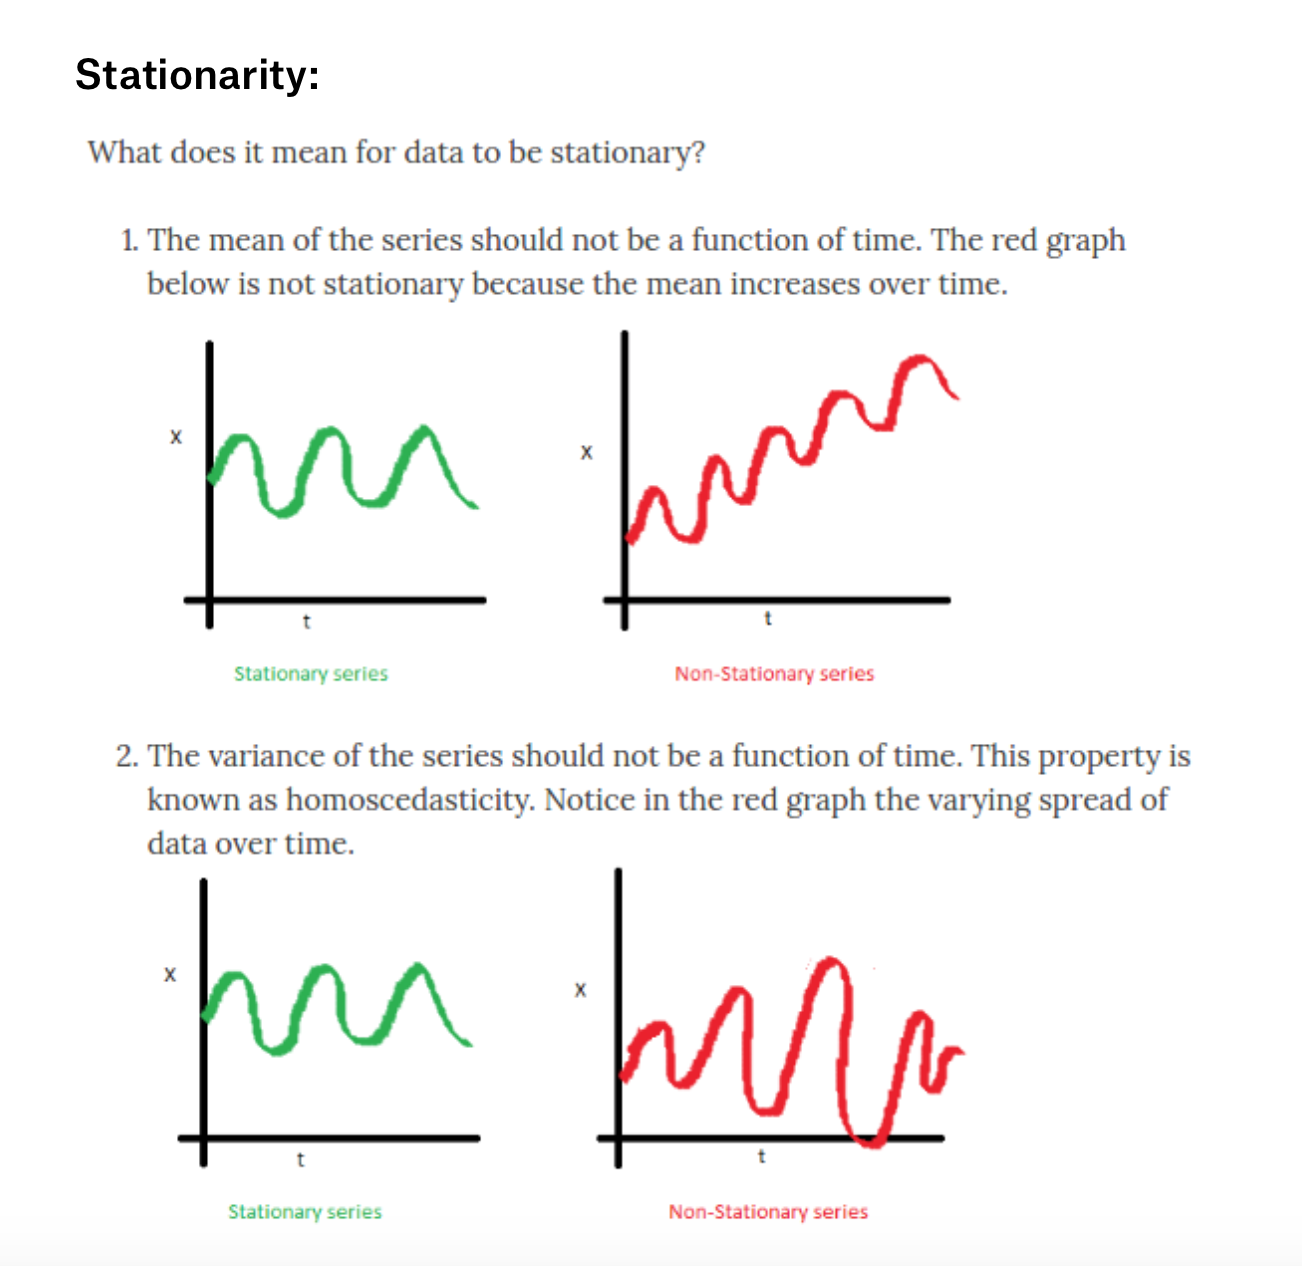

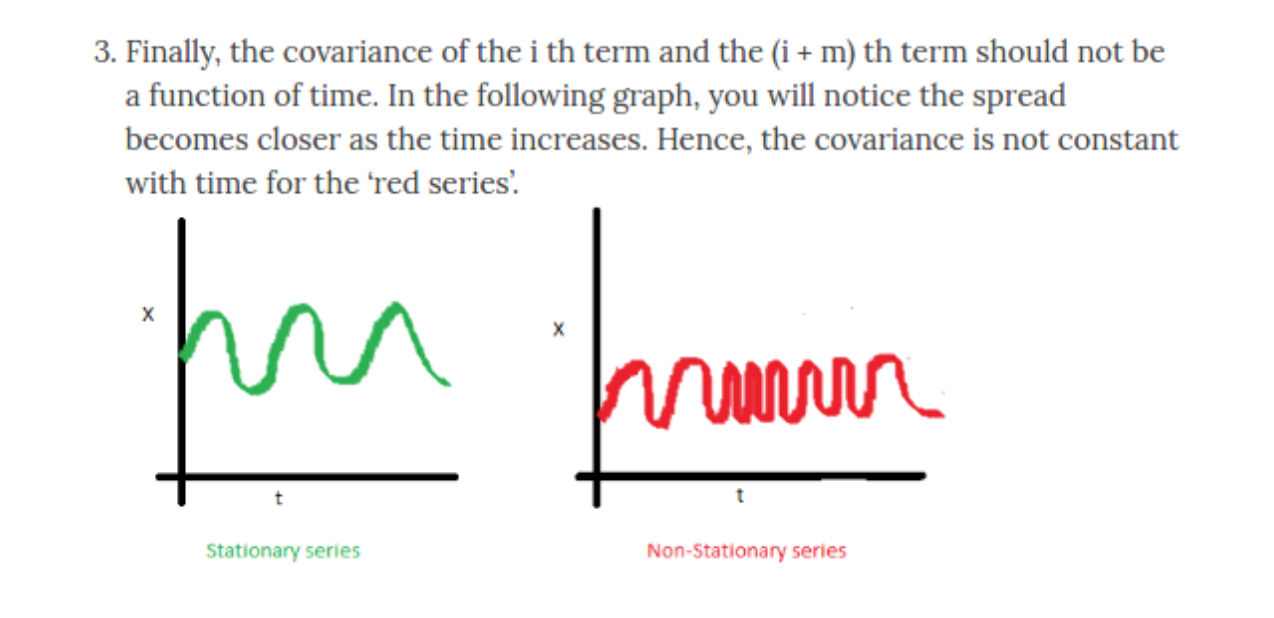

一个时间序列，如果均值没有系统的变化（无趋势）、方差没有系统变化，且严格消除了周期性变化，就称之是平稳的。

In [ ]:
ts.test_stationarity(item_cnt_month_ts)

In [ ]:
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(item_cnt_month_ts)

plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts= td.difference(item_cnt_month_ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts= td.difference(item_cnt_month_ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [ ]:
new_ts = td.difference(item_cnt_month_ts)

In [ ]:
ts.test_stationarity(new_ts)

### Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 387 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.

In [22]:
test.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [32]:
raw_features[["item_id","shop_id"]].nunique()

item_id    21702
shop_id       60
dtype: int64

In [33]:
len(set(test["item_id"].tolist())  - set(raw_features["item_id"].tolist()))

387

In [34]:
len(set(test["shop_id"].tolist())  - set(raw_features["shop_id"].tolist()))

0

In [35]:
unique_item_id = set(test["item_id"].tolist()).union(set(raw_features["item_id"].tolist()))
unique_shop_id = set(test["shop_id"].tolist()).union(set(raw_features["shop_id"].tolist()))

In [36]:
len(unique_item_id), len(unique_shop_id)

(22089, 60)

In [37]:
34 * len(unique_item_id) * len(unique_shop_id)

45061560

In [39]:
matrix = np.empty((34 * len(unique_item_id) * len(unique_shop_id),3))
cols = ['date_block_num','shop_id','item_id']

for index, (date_block,shop_id,item_id) in enumerate(product(range(34), list(unique_shop_id), list(unique_item_id))):
    matrix[index,:] = [date_block,shop_id,item_id]
    
matrix = pd.DataFrame(matrix, columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int16)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [40]:
group = raw_features.groupby(cols).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [41]:
matrix = matrix.merge(group, on=cols, how='left').fillna(0)

In [46]:
mask = matrix.groupby(["shop_id","item_id"]).agg({"item_cnt_month": "mean"}).reset_index()

In [47]:
filtered_matrix = matrix.merge(mask.loc[mask["item_cnt_month"] >= 1,["shop_id","item_id"]], on = ["shop_id","item_id"], how = "inner")

In [48]:
filtered_matrix = filtered_matrix.merge(items, left_on ="item_id", right_on = "item_id")
filtered_matrix = filtered_matrix.merge(shops, left_on = "shop_id", right_on = "shop_id")
filtered_matrix.drop(["item_name","shop_name"], axis = 1, inplace = True)

In [49]:
filtered_matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id
0,0,0,1871,21.0,30
1,1,0,1871,21.0,30
2,2,0,1871,0.0,30
3,3,0,1871,0.0,30
4,4,0,1871,0.0,30


## Sample 

In [134]:
train_data = []
targets = []

for name,group in filtered_matrix.groupby(["shop_id","item_id"]):
    train_data.append(group.iloc[:33,[3,4]].values)
    targets.append(group.iloc[33,[3]].values[0])

In [135]:
training_matrix = np.empty((len(train_data),*train_data[0].shape))

In [136]:
training_matrix.shape, training_matrix[0].shape

((17776, 33, 2), (33, 2))

In [137]:
targets = np.array(targets)

In [138]:
for i, data in enumerate(train_data):
    training_matrix[i,:,:] = data

In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    training_matrix, targets, test_size=0.2, random_state=0)

In [140]:
X_train.shape, y_train.shape

((14220, 33, 2), (14220,))

In [147]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
import numpy as np

data_dim = 2
timesteps = 33

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential([
    LSTM(64, return_sequences=True,
               input_shape=(timesteps, data_dim)),  # returns a sequence of vectors of dimension 32
    Dropout(0.4),
    Dense(1)])


model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])


In [148]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 33, 64)            17152     
_________________________________________________________________
dropout_10 (Dropout)         (None, 33, 64)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


In [149]:
history = model.fit(X_train, y_train,
          batch_size=128, epochs=200,
          validation_data=(X_test, y_test))

Train on 14220 samples, validate on 3556 samples
Epoch 1/200
14220/14220 [==============================] - 7s 490us/step - loss: 95.7406 - mse: 95.7406 - val_loss: 33.3401 - val_mse: 33.3401
Epoch 2/200
14220/14220 [==============================] - 6s 404us/step - loss: 91.7807 - mse: 91.7807 - val_loss: 29.6044 - val_mse: 29.6044
Epoch 3/200
14220/14220 [==============================] - 6s 400us/step - loss: 88.8568 - mse: 88.8568 - val_loss: 27.1718 - val_mse: 27.1718
Epoch 4/200
14220/14220 [==============================] - 6s 401us/step - loss: 86.8069 - mse: 86.8069 - val_loss: 26.6675 - val_mse: 26.6675
Epoch 5/200
14220/14220 [==============================] - 6s 408us/step - loss: 85.1029 - mse: 85.1029 - val_loss: 25.0060 - val_mse: 25.0060
Epoch 6/200
14220/14220 [==============================] - 6s 410us/step - loss: 84.4366 - mse: 84.4366 - val_loss: 24.5199 - val_mse: 24.5199
Epoch 7/200
14220/14220 [==============================] - 6s 398us/step - loss: 82.6317 - ms

14220/14220 [==============================] - 6s 397us/step - loss: 57.3226 - mse: 57.3226 - val_loss: 11.6657 - val_mse: 11.6657
Epoch 58/200
14220/14220 [==============================] - 6s 393us/step - loss: 58.8168 - mse: 58.8167 - val_loss: 12.0136 - val_mse: 12.0136
Epoch 59/200
14220/14220 [==============================] - 5s 384us/step - loss: 57.8090 - mse: 57.8090 - val_loss: 11.5581 - val_mse: 11.5581
Epoch 60/200
14220/14220 [==============================] - 6s 394us/step - loss: 57.7298 - mse: 57.7298 - val_loss: 11.4224 - val_mse: 11.4224
Epoch 61/200
14220/14220 [==============================] - 6s 395us/step - loss: 57.1082 - mse: 57.1082 - val_loss: 11.4686 - val_mse: 11.4686
Epoch 62/200
14220/14220 [==============================] - 6s 389us/step - loss: 56.3623 - mse: 56.3623 - val_loss: 11.4376 - val_mse: 11.4376
Epoch 63/200
14220/14220 [==============================] - 5s 380us/step - loss: 58.4343 - mse: 58.4343 - val_loss: 11.1472 - val_mse: 11.1472
Epoch

Epoch 114/200
14220/14220 [==============================] - 6s 398us/step - loss: 50.3916 - mse: 50.3916 - val_loss: 11.1311 - val_mse: 11.1311
Epoch 115/200
14220/14220 [==============================] - 6s 401us/step - loss: 49.4973 - mse: 49.4973 - val_loss: 10.8800 - val_mse: 10.8800
Epoch 116/200
14220/14220 [==============================] - 6s 399us/step - loss: 53.5147 - mse: 53.5147 - val_loss: 10.7328 - val_mse: 10.7328
Epoch 117/200
14220/14220 [==============================] - 6s 399us/step - loss: 50.7369 - mse: 50.7369 - val_loss: 10.7176 - val_mse: 10.7176
Epoch 118/200
14220/14220 [==============================] - 6s 398us/step - loss: 49.2221 - mse: 49.2222 - val_loss: 11.2625 - val_mse: 11.2625
Epoch 119/200
14220/14220 [==============================] - 6s 409us/step - loss: 50.7748 - mse: 50.7748 - val_loss: 10.7168 - val_mse: 10.7168
Epoch 120/200
14220/14220 [==============================] - 6s 436us/step - loss: 50.0102 - mse: 50.0102 - val_loss: 11.2730 - va

14220/14220 [==============================] - 6s 405us/step - loss: 54.7658 - mse: 54.7658 - val_loss: 11.7221 - val_mse: 11.7221
Epoch 171/200
14220/14220 [==============================] - 6s 402us/step - loss: 42.0053 - mse: 42.0053 - val_loss: 10.8421 - val_mse: 10.8421
Epoch 172/200
14220/14220 [==============================] - 6s 404us/step - loss: 43.9367 - mse: 43.9367 - val_loss: 11.2925 - val_mse: 11.2925
Epoch 173/200
14220/14220 [==============================] - 6s 407us/step - loss: 45.0512 - mse: 45.0512 - val_loss: 10.7699 - val_mse: 10.7699
Epoch 174/200
14220/14220 [==============================] - 6s 404us/step - loss: 42.0708 - mse: 42.0708 - val_loss: 11.1301 - val_mse: 11.1301
Epoch 175/200
14220/14220 [==============================] - 6s 407us/step - loss: 42.6548 - mse: 42.6548 - val_loss: 10.7552 - val_mse: 10.7552
Epoch 176/200
14220/14220 [==============================] - 6s 404us/step - loss: 42.0680 - mse: 42.0680 - val_loss: 10.5346 - val_mse: 10.5346

In [150]:
model.save("lstm_model.h5")

## Model

## Test set

In [151]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,0,0.0
1,0,0,1,0.0
2,0,0,2,0.0
3,0,0,3,0.0
4,0,0,4,0.0


In [152]:
test_set = matrix.merge(test,on = ["shop_id","item_id"],how = "inner")
test_set = test_set.merge(items, left_on ="item_id", right_on = "item_id")
test_set = test_set.merge(shops, left_on = "shop_id", right_on = "shop_id")
test_set.drop(["item_name","shop_name","ID"], axis = 1, inplace = True)

In [155]:
test_data = []
shop_item_id = []
for name,group in test_set.groupby(["shop_id","item_id"]):
    shop_item_id.append(name)
    test_data.append(group.iloc[1:,[3,4]].values)

In [156]:
test_matrix = np.empty((len(test_data),*test_data[0].shape))

In [157]:
for i, data in enumerate(test_data):
    test_matrix[i,:,:] = data

In [158]:
with open("test_matrix.pkl","wb") as f:
    pkl.dump(test_matrix,f)

In [159]:
import pickle as pkl
from keras.models import load_model

In [2]:
model = load_model("lstm_model.h5")

In [3]:
with open("test_matrix.pkl","rb") as f:
    test_matrix = pkl.load(f)

In [172]:
y_pre = model.predict(test_matrix)

In [165]:
pred_df = pd.DataFrame(np.hstack([np.array(shop_item_id),y_pre]),columns = ["shop_id","item_id","item_cnt_month"])

In [166]:
res = test.merge(pred_df,on = ["shop_id","item_id"]).drop(["shop_id","item_id"], axis = 1)

In [167]:
res.to_csv("submission.csv",index = False)